# Analyse results

Useful references:
* https://pypsa.readthedocs.io/en/latest/examples/scigrid-lopf-then-pf.html (example from PyPSA documentation with many different visualisations)

## Setup and helpers

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import pypsa
import yaml

# plotting settings
plt.style.use('ggplot') # what is this?
plt.rcParams['figure.figsize'] = (6, 6)
projection = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52) # good for Europe

# Load the network
network_file = "../results/normal/networks/base_s_39_Co2L-175H-CCL__2050.nc"
network = pypsa.Network(network_file)

# Load the config file
with open("../config/config.yaml") as stream:
    config = yaml.safe_load(stream)

def plot_europe(fig, ax):
    ax.set_extent([-10, 40, 35, 70], crs=ccrs.PlateCarree()) # Europe
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')
    ax.add_feature(cfeature.LAKES, facecolor='lightblue', alpha=0.8)
    ax.add_feature(cfeature.RIVERS, edgecolor='lightblue', alpha=0.8)

    gl = ax.gridlines(draw_labels=True, color="gray", alpha=0.5, linestyle="--")
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels

    return fig, ax

INFO:pypsa.io:Imported network base_s_39_Co2L-175H-CCL__2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


## Network map

/Users/jopeel/miniconda3/envs/pypsa-eur/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


(<matplotlib.collections.PatchCollection at 0x309de3e60>,
 <matplotlib.collections.LineCollection at 0x316397770>)

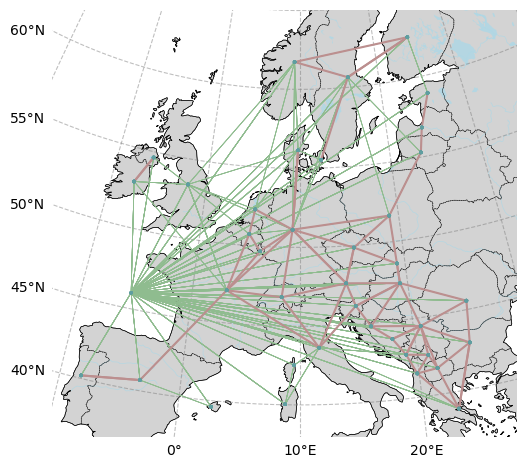

In [8]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': projection})

fig, ax = plot_europe(fig, ax)

network.plot(ax=ax, link_widths=0.5)

## Load distribution map

/Users/jopeel/miniconda3/envs/pypsa-eur/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


(<matplotlib.collections.PatchCollection at 0x316454770>,
 <matplotlib.collections.LineCollection at 0x31643c590>)

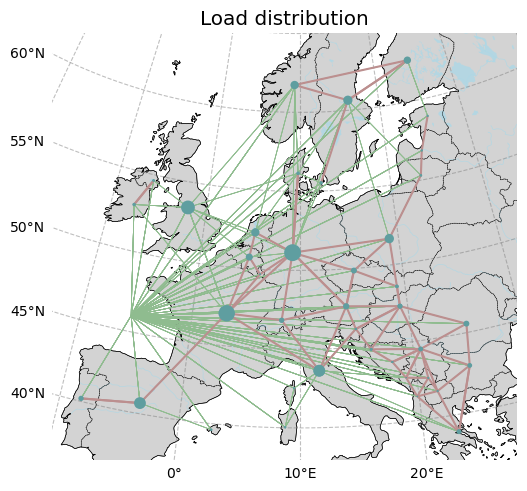

In [10]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": projection})

fig, ax = plot_europe(fig, ax)

load_distribution = (
    network.loads_t.p_set.loc[network.snapshots[0]].groupby(network.loads.bus).sum()
)

network.plot(bus_sizes=1e-5 * load_distribution, ax=ax, link_widths=0.5, title="Load distribution")

## Installed capacities table

In [20]:
df = network.generators.groupby("carrier")["p_nom"].sum()
print(df)

carrier
offwind-ac                         9150.234286
offwind-dc                        15855.398550
onwind                           184721.712000
ror                               45716.007854
rural solar thermal                   0.000000
solar                            152551.138000
solar rooftop                         0.000000
urban central solar thermal           0.000000
urban decentral solar thermal         0.000000
Name: p_nom, dtype: float64


In [22]:
network.storage_units.groupby("carrier")["p_nom"].sum()

carrier
PHS       56877.540000
hydro    103133.331377
Name: p_nom, dtype: float64

Index(['bus', 'control', 'type', 'p_nom', 'p_nom_mod', 'p_nom_extendable',
       'p_nom_min', 'p_nom_max', 'p_min_pu', 'p_max_pu', 'p_set', 'q_set',
       'sign', 'carrier', 'spill_cost', 'marginal_cost',
       'marginal_cost_quadratic', 'marginal_cost_storage', 'capital_cost',
       'active', 'build_year', 'lifetime', 'state_of_charge_initial',
       'state_of_charge_initial_per_period', 'state_of_charge_set',
       'cyclic_state_of_charge', 'cyclic_state_of_charge_per_period',
       'max_hours', 'efficiency_store', 'efficiency_dispatch', 'standing_loss',
       'inflow', 'p_nom_opt'],
      dtype='object')

## Dispatch plot

/var/folders/cd/3symzw7d0833vd8qj4shbrl80000gp/T/ipykernel_41062/1635151601.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  p_by_carrier = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()


carrier              Offshore Wind (AC)  Offshore Wind (DC)   Onshore Wind  \
snapshot                                                                     
2013-01-01 00:00:00        28935.881522        68458.237822  339807.532963   
2013-01-08 07:00:00        28952.850936        49326.601055  194644.495618   
2013-01-15 14:00:00        32571.198220        65852.413972  295944.835556   
2013-01-22 21:00:00        37189.126715        72268.297991  416229.877756   
2013-01-30 04:00:00        42468.089174        80068.524943  456879.271886   
2013-02-06 11:00:00        26554.823203        54828.124037  249480.042970   
2013-02-13 18:00:00        25967.474228        48625.230189  204007.472456   
2013-02-21 01:00:00        36403.404672        61887.036164  220040.178266   
2013-02-28 08:00:00        29734.193954        62850.056933  217731.974576   
2013-03-07 15:00:00        33604.958483        63248.327748  351593.963343   
2013-03-14 22:00:00        36416.130875        74021.742963  321

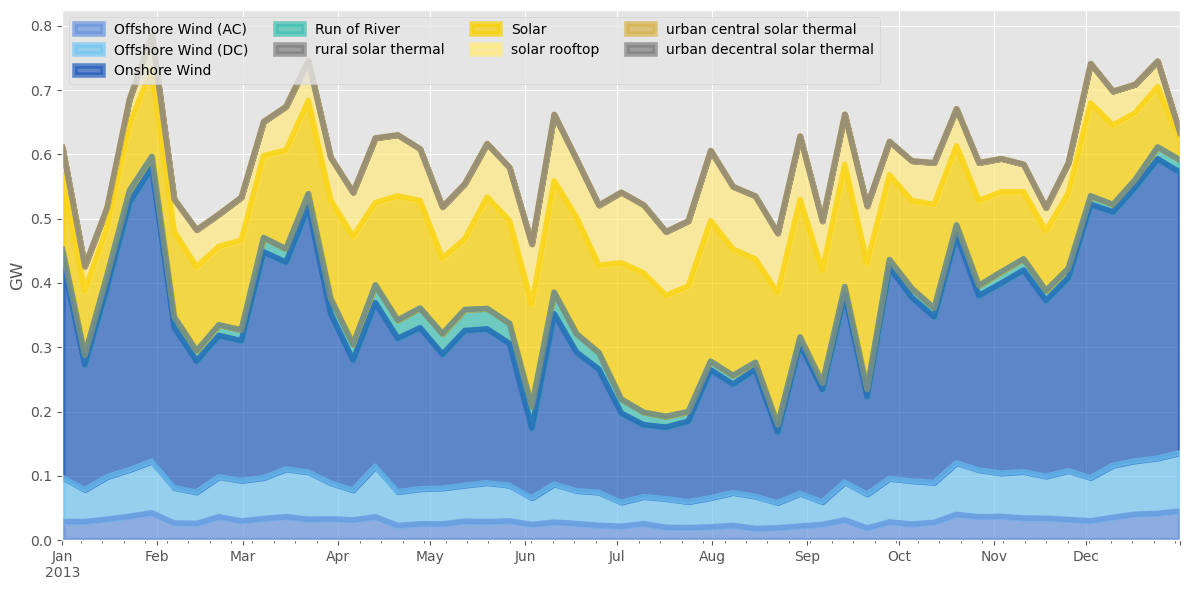

In [ ]:
# plot power dispatch with time

p_by_carrier = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()

all_colors = config["plotting"]["tech_colors"]

colors = []
for col in p_by_carrier.columns:
    try:
        colors.append(all_colors[col])
    except KeyError:
        colors.append("gray")

# colors = [all_colors[col] for col in p_by_carrier.columns]

p_by_carrier.rename(columns=config["plotting"]["nice_names"], inplace=True)
print(p_by_carrier)

# time_range = pd.date_range(start="2013-01-01 00:00:00", end="2013-02-01 00:00:00")
# p_by_carrier = p_by_carrier.loc[time_range]

p_by_carrier = p_by_carrier / 1e3

fig, ax = plt.subplots(figsize=(12, 6))
(p_by_carrier / 1e3).plot(kind="area", ax=ax, linewidth=4, color=colors, alpha=0.7)
ax.legend(ncol=4, loc="upper left")
ax.set_ylabel("GW")
ax.set_xlabel("")
fig.tight_layout()

## Storage plot

/var/folders/cd/3symzw7d0833vd8qj4shbrl80000gp/T/ipykernel_41062/4047808845.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  soc = network.storage_units_t["state_of_charge"].groupby(network.storage_units.carrier, axis=1).sum()


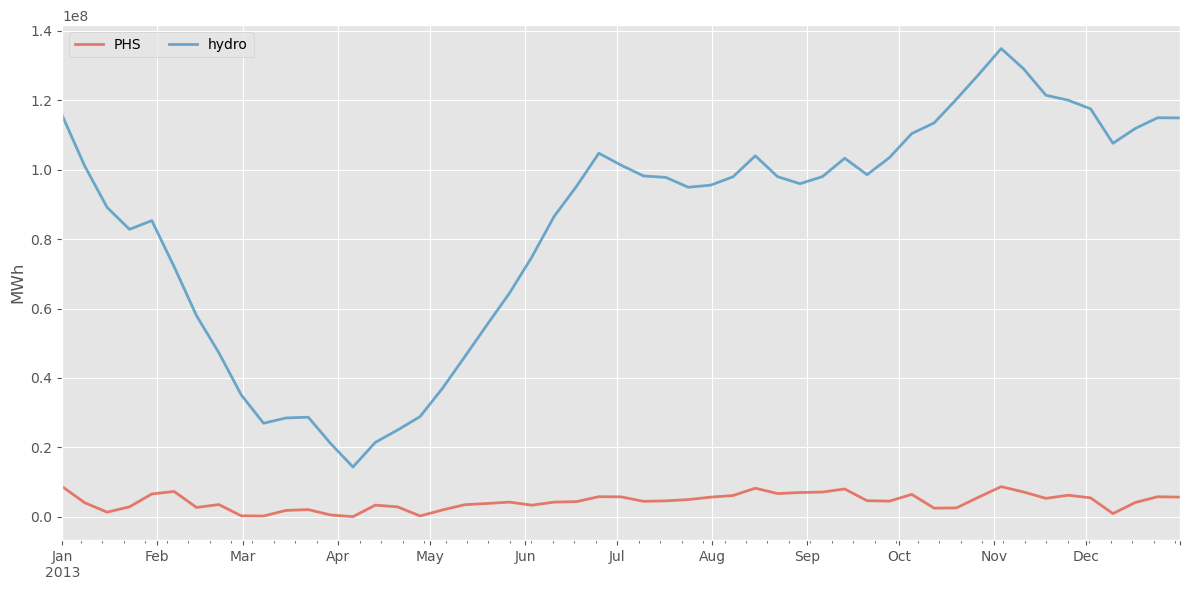

In [44]:
## plot storage capacities with time

soc = network.storage_units_t["state_of_charge"].groupby(network.storage_units.carrier, axis=1).sum()

fig, ax = plt.subplots(figsize=(12, 6))
soc.plot(ax=ax, linewidth=2, alpha=0.7)
ax.legend(ncol=4, loc="upper left")
ax.set_ylabel("MWh")
ax.set_xlabel("")
fig.tight_layout()